# Gapminders

In his Gapminder example during thes 2006 TED Talk, Hans Rosling debunked stereotypes about developed and undeveloped countries using statistics and data visualization, revealing the nuanced reality of global development. We will be recreating this example using four different plotting libraries which will be controlled by widgets from Panel.

<img src="./assets/dashboard.png" alt="Gapminder app with 4 plots" />

In [26]:
import warnings

import numpy as np 
import pandas as pd
import panel as pn

import altair as alt
import plotly.graph_objs as go
import plotly.io as pio
import matplotlib.pyplot as plt
import matplotlib as mpl
import hvplot.pandas  # noqa

warnings.simplefilter('ignore')
pn.extension('vega', 'plotly', defer_load=True, sizing_mode="stretch_width")
mpl.use('agg')

We'll begin by defining some global variables for our plots.

In [47]:
XLABEL = 'GDP per capita (2000 dollars)'
YLABEL = 'Life expectancy (years)'
YLIM = (20, 90)
HEIGHT=500 # pixels
WIDTH=500 # pixels
ACCENT="#00A170"
PERIOD = 1000 # miliseconds

## Extract the dataset

First, we'll get the data into a Pandas dataframe. We use the [built in `cache`](https://panel.holoviz.org/user_guide/Performance_and_Debugging.html#caching) to speed up the app.

In [28]:
@pn.cache
def get_dataset():
    url = 'https://raw.githubusercontent.com/plotly/datasets/master/gapminderDataFiveYear.csv'
    return pd.read_csv(url)

In [29]:
dataset = get_dataset()
dataset.sample(10)

,country,year,pop,continent,lifeExp,gdpPercap
1416,Spain,1952,28549870.0,Europe,64.940,3834.034742
814,Jordan,2002,5307470.0,Asia,71.263,3844.917194
83,Austria,2007,8199783.0,Europe,79.829,36126.492700
786,Jamaica,1982,2298309.0,Americas,71.210,6068.051350
1263,Reunion,1967,414024.0,Africa,60.542,4021.175739
85,Bahrain,1957,138655.0,Asia,53.832,11635.799450
226,Cambodia,2002,12926707.0,Asia,56.752,896.226015
215,Burundi,2007,8390505.0,Africa,49.580,430.070692
849,"Korea, Rep.",1997,46173816.0,Asia,74.647,15993.527960
1545,Togo,1997,4320890.0,Africa,58.390,982.286924


We'll also create a global variable `YEARS` containing all the unique years in our dataset.

In [30]:
YEARS = [int(year) for year in dataset.year.unique()]
YEARS

[1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007]

## Transform the dataset to plots

Now let's define helper functions and functions to plot this dataset with Matplotlib, Plotly, Altair, and hvPlot (using HoloViews and Bokeh).

In [48]:
@pn.cache
def get_data(year):
    df = dataset[(dataset.year==year) & (dataset.gdpPercap < 10000)].copy()
    df['size'] = np.sqrt(df['pop']*2.666051223553066e-05)
    df['size_hvplot'] = df['size']*6
    return df

def get_title(library, year):
    return f"{library}: Life expectancy vs. GDP, {year}"

def get_xlim(data):
    return (dataset['gdpPercap'].min()-100, dataset[dataset['gdpPercap'] < 10000].max()['gdpPercap']+1000)

Let's define the **Matplotlib** plotting function.

In [49]:
plt.rcParams.update({
    "savefig.facecolor": (0.0, 0.0, 0.0, 0.0), 
})


def mpl_view(year=1952, show_legend=True):
    data = get_data(year)
    title = get_title("Matplotlib", year)
    xlim = get_xlim(data)

    plot = plt.figure(figsize=(10, 8), facecolor=(0, 0, 0, 0))
    ax = plot.add_subplot(111)
    ax.set_xscale("log")
    ax.set_title(title)
    ax.set_xlabel(XLABEL)
    ax.set_ylabel(YLABEL)
    ax.set_ylim(YLIM)
    ax.set_xlim(xlim)

    for continent, df in data.groupby('continent'):
        ax.scatter(df.gdpPercap, y=df.lifeExp, s=df['size']*5,
                   edgecolor='black', label=continent)

    if show_legend:
        ax.legend(loc=4)

    plt.close(plot)
    return plot

mpl_view(1952, True)

<Figure size 1000x800 with 1 Axes>

Let's define the **Plotly** plotting function.

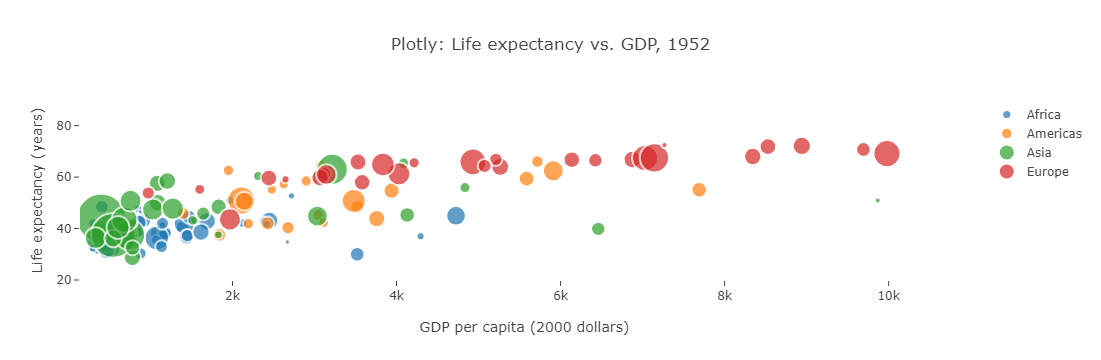

In [50]:
pio.templates.default = None

def plotly_view(year=1952, show_legend=True):
    data = get_data(year)
    title = get_title("Plotly", year)
    xlim = get_xlim(data)
    ylim = YLIM
    traces = []
    for continent, df in data.groupby('continent'):
        marker=dict(symbol='circle', sizemode='area', sizeref=0.1, size=df['size'], line=dict(width=2))
        traces.append(go.Scatter(x=df.gdpPercap, y=df.lifeExp, mode='markers', marker=marker, name=continent, text=df.country))

    axis_opts = dict(gridcolor='rgb(255, 255, 255)', zerolinewidth=1, ticklen=5, gridwidth=2)
    layout = go.Layout(
        title=title, showlegend=show_legend,
        xaxis=dict(title=XLABEL, type='linear', range=xlim, **axis_opts),
        yaxis=dict(title=YLABEL, range=YLIM, **axis_opts),
        autosize=True, paper_bgcolor='rgba(0,0,0,0)',
    )
    return go.Figure(data=traces, layout=layout)

plotly_view()

Let's define the **Altair** plotting function.

In [51]:
def altair_view(year=1952, show_legend=True, height="container", width="container"):
    data = get_data(year)
    title = get_title("Altair/ Vega", year)
    xlim = get_xlim(data)
    legend= ({} if show_legend else {'legend': None})
    return (
        alt.Chart(data)
            .mark_circle().encode(
                alt.X('gdpPercap:Q', scale=alt.Scale(type='log'), axis=alt.Axis(title=XLABEL)),
                alt.Y('lifeExp:Q', scale=alt.Scale(zero=False, domain=YLIM), axis=alt.Axis(title=YLABEL)),
                size=alt.Size('pop:Q', scale=alt.Scale(type="log"), legend=None),
                color=alt.Color('continent', scale=alt.Scale(scheme="category10"), **legend),
                tooltip=['continent','country'])
            .configure_axis(grid=False)
            .properties(title=title, height=height, width=width, background='rgba(0,0,0,0)') 
            .configure_view(fill="white")
            .interactive()
    )

altair_view(height=HEIGHT-100, width=1000)

alt.Chart(...)

Let's define the **hvPlot** plotting function. Please note that [hvPlot](https://hvplot.holoviz.org/) is the recommended entry point to the HoloViz plotting ecosystem.

In [52]:
def hvplot_view(year=1952, show_legend=True):
    data = get_data(year)
    title = get_title("hvPlot/ Bokeh", year)
    xlim = get_xlim(data)

    return data.hvplot.scatter(
        'gdpPercap', 'lifeExp', by='continent', s='size_hvplot', alpha=0.8,
        logx=True, title=title, legend='bottom_right',
        hover_cols=['country'], ylim=YLIM, xlim=xlim, ylabel=YLABEL, xlabel=XLABEL, height=400

    )

hvplot_view()

:NdOverlay   [continent]
   :Scatter   [gdpPercap]   (lifeExp,size_hvplot,country)

## Define the widgets

Next we will set up a periodic callback to allow cycling through the years with a slider and checkbox widget for showing the legend. These widgets allow user to interact with our app.

In [36]:
year = pn.widgets.DiscreteSlider(value=YEARS[-1], options=YEARS, name="Year")
show_legend = pn.widgets.Checkbox(value=True, name="Show Legend")

In [37]:
def play():
    if year.value == YEARS[-1]:
        year.value=YEARS[0]
        return
    
    index = YEARS.index(year.value)
    year.value = YEARS[index+1]    

periodic_callback = pn.state.add_periodic_callback(play, start=False, period=PERIOD)
player = pn.widgets.Checkbox.from_param(periodic_callback.param.running, name="Autoplay")

In [38]:
widgets = pn.Column(year, player, show_legend, margin=(0,15))
widgets

Column(margin=(0, 15), sizing_mode='stretch_width')
    [0] DiscreteSlider(formatter='%d', name='Year', options=[1952, 1957, 1962, ...], sizing_mode='stretch_width', value=2007)
    [1] Checkbox(name='Autoplay', sizing_mode='stretch_width')
    [2] Checkbox(name='Show Legend', sizing_mode='stretch_width', value=True)

## Layout the widgets

Now we can craete a Panel layout containing a logo, description and the widgets through the use of `pn.Column`.

In [53]:
logo = pn.pane.PNG(
    "https://panel.holoviz.org/_static/logo_stacked.png",
    link_url="https://panel.holoviz.org", embed=False, width=150, align="center"
)

desc = pn.pane.Markdown("""## 🎓 Info

The [Panel](http://panel.holoviz.org) library from [HoloViz](https://holoviz.org)
lets you make widget-controlled apps and dashboards from a wide variety of 
plotting libraries and data types. Here you can try out four different plotting libraries
controlled by a couple of widgets, for Hans Rosling's 
[gapminder](https://demo.bokeh.org/gapminder) example.
""")

settings = pn.Column(logo, "## ⚙️ Settings", widgets, desc)
settings

Column(sizing_mode='stretch_width')
    [0] PNG(str, align='center', link_url='https://panel.holoviz.org..., width=150)
    [1] Markdown(str, sizing_mode='stretch_width')
    [2] Column(margin=(0, 15), sizing_mode='stretch_width')
        [0] DiscreteSlider(formatter='%d', name='Year', options=[1952, 1957, 1962, ...], sizing_mode='stretch_width', value=2007)
        [1] Checkbox(name='Autoplay', sizing_mode='stretch_width')
        [2] Checkbox(name='Show Legend', sizing_mode='stretch_width', value=True)
    [3] Markdown(str, sizing_mode='stretch_width')

## Bind widgets to plots

Next, let's create a function that will generate a list of plots encapsulated in `pn.pane` objects. It takes parameters for the year and whether to display legends on the plots

In [46]:
def update_views(year, show_legend):
    mpl_v = mpl_view(year=year, show_legend=show_legend)
    plotly_v = plotly_view(year=year, show_legend=show_legend)
    altair_v = altair_view(year=year, show_legend=show_legend)
    hvplot_v = hvplot_view(year=year, show_legend=show_legend)

    return [
        pn.pane.Matplotlib(mpl_v, format='png', sizing_mode='stretch_both', tight=True, margin=10),
        pn.pane.HoloViews(hvplot_v, sizing_mode='stretch_both', margin=10),
        pn.pane.Plotly(plotly_v, sizing_mode='stretch_both', margin=10),
        pn.pane.Vega(altair_v, sizing_mode='stretch_both', margin=10)
    ]

Then we will call `pn.bind` using the function created above. This will update the plots whenever the slider widget is moved. 
We layout the plots in a [Gridbox](https://panel.holoviz.org/reference/layouts/GridBox.html) with 2 columns. Panel provides many other [layouts](https://panel.holoviz.org/reference/index.html#layouts) that might be perfect for your use case.

GridBox(ncols=2, sizing_mode='stretch_both')
    [0] Matplotlib(Figure, margin=10, sizing_mode='stretch_both', tight=True)
    [1] HoloViews(NdOverlay, height=400, margin=10, sizing_mode='stretch_both', width=700)
    [2] Plotly(Figure, margin=10, sizing_mode='stretch_both')
    [3] Vega(Chart, margin=10, selection=Selection, sizing_mode='stretch_both')
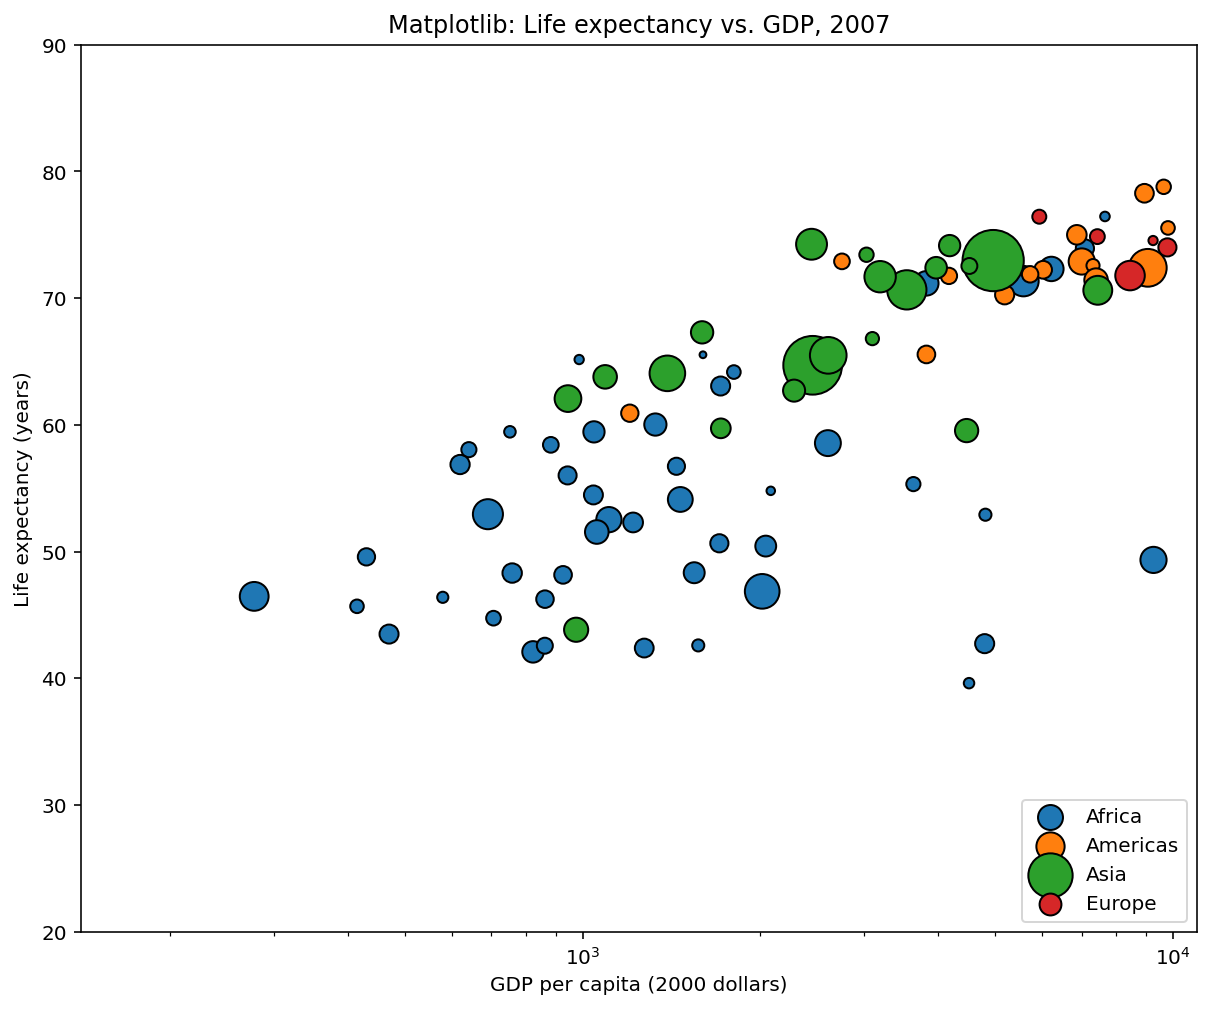

In [41]:
gridbox = pn.layout.GridBox(
    objects = pn.bind(update_views, year=year, show_legend=show_legend),   
    ncols=2,
    sizing_mode="stretch_both"
)

gridbox

## Configure the template

Let us layout out the app in the nicely styled with [FastListTemplate](https://panel.holoviz.org/reference/templates/FastListTemplate.html).

In [42]:
pn.template.FastListTemplate(
    sidebar=[settings],
    main=[gridbox],
    site="Panel",
    site_url="https://panel.holoviz.org",
    title="Hans Rosling's Gapminder",
    header_background=ACCENT,
    accent_base_color=ACCENT,
    favicon="static/extensions/panel/images/favicon.ico",
    theme_toggle=False,
).servable();  # We add ; to avoid showing the app in the notebook

Congrats, you are finished! The final data app can be served via `panel serve gapminders.ipynb`.

It will look something like.

<img src="./assets/dashboard.png" alt="Gapminder app with 4 plots" />